# About this Notebook

The goal of this notebook is to build a classifier using a BERT pre-trained model to find toxic comments. The data has been taken from a series of Kaggle competitions to classify Wikipedia comments as toxic/nontoxic. The data has been sourced from Google and Jigsaw. 

Though the full dataset includes non-English comments, I will restrict myself to English-only comment for this iteration. 

For metrics, I will focus on both AUC for ROC and precision-recall curves. In addition, I will look at overall accuracy and perhaps the confusion matrix and performance across different flavors of toxicity.

Credits:
- https://www.kaggle.com/tanulsingh077/deep-learning-for-nlp-zero-to-transformers-bert
- https://www.kaggle.com/jagangupta/stop-the-s-toxic-comments-eda
- https://www.kaggle.com/clinma/eda-toxic-comment-classification-challenge
- https://www.kaggle.com/abhi111/naive-bayes-baseline-and-logistic-regression

In [18]:
import numpy as np
import pandas as pd 
from tqdm import tqdm 

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


pd.options.display.max_rows = 999

In [ ]:
from toxicity import constants, data, features, text_preprocessing, model, metrics, visualize


## Load data

In [3]:
input_data_path = './../'+constants.INPUT_PATH
df_train = data.load(input_data_path, filter=False)

In [4]:
xtrain, xvalid, ytrain, yvalid = model.make_train_test(df_train)

## Transformers/Attention/BERT

In [6]:
# Loading Dependencies
import os
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.metrics import Accuracy, AUC
#from kaggle_datasets import KaggleDatasets
import transformers

from tokenizers import BertWordPieceTokenizer

Using huggingface's tokenizer and DistilBert Model.
https://huggingface.co/transformers/main_classes/tokenizer.html

In [7]:
#IMP DATA FOR CONFIG
#AUTO = tf.data.experimental.AUTOTUNE

# Configuration
EPOCHS = 3
BATCH_SIZE = 16 
MAX_LEN = 512

In [11]:
def fast_encode(texts, tokenizer, chunk_size=256, maxlen=MAX_LEN):
    """
    Encoder for encoding the text into sequence of integers for BERT Input
    """
    #Only a small fraction of input is > maxlen, not biased across toxic/nontoxic.
    tokenizer.enable_truncation(max_length=maxlen)
    tokenizer.enable_padding(length=maxlen)
    all_ids = []
    
    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])
    
    return np.array(all_ids)

## Tokenization

For understanding please refer to hugging face documentation again

In [12]:
# First load the real tokenizer
tokenizer = transformers.DistilBertTokenizer.from_pretrained('distilbert-base-cased')
# Save the loaded tokenizer locally
tokenizer.save_pretrained('.')
# Reload it with the huggingface tokenizers library
fast_tokenizer = BertWordPieceTokenizer('vocab.txt', lowercase=False)
fast_tokenizer

Tokenizer(vocabulary_size=28996, model=BertWordPiece, unk_token=[UNK], sep_token=[SEP], cls_token=[CLS], pad_token=[PAD], mask_token=[MASK], clean_text=True, handle_chinese_chars=True, strip_accents=None, lowercase=False, wordpieces_prefix=##)

In [19]:
x_train = fast_encode(xtrain.astype(str), fast_tokenizer, maxlen=MAX_LEN)
x_valid = fast_encode(xvalid.astype(str), fast_tokenizer, maxlen=MAX_LEN)
#x_test = fast_encode(test.content.astype(str), fast_tokenizer, maxlen=MAX_LEN)

y_train = ytrain
y_valid = yvalid

100%|██████████| 175/175 [00:05<00:00, 30.82it/s]


In [20]:
def sample(input, n=50):
    return input[0:n]

x_train_s = sample(x_train)
x_valid_s = sample(x_valid)
y_train_s = sample(y_train)
y_valid_s = sample(y_valid)

In [ ]:
def build_model(transformer, max_len=MAX_LEN, transformer_trainable=False):
    """
    function for training the BERT model
    """
    transformer.trainable = transformer_trainable
    input_word_ids = Input(shape=(max_len,), dtype='int32', name="input_word_ids")
    sequence_output = transformer(input_word_ids)[0]
    cls_token = sequence_output[:, 0, :]
    dense_1 = Dense(200, activation='relu')(cls_token)
    out = Dense(1, activation='sigmoid')(dense_1)
    
    model = Model(inputs=input_word_ids, outputs=out)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy', AUC(curve='PR')])
    
    return model

## Starting Training

If you want to use any another model just replace the model name in transformers._____ and use accordingly

In [ ]:
%%time

transformer_layer = (
    transformers.TFDistilBertModel
    .from_pretrained('distilbert-base-cased')
)



## Trainable vs. frozen variables

In [ ]:
model = build_model(transformer_layer, max_len=MAX_LEN)
model.summary()


## Callbacks

In [21]:
# Create a callback for tensorboard
tb_callback = TensorBoard(log_dir='./Graph', histogram_freq=0, write_graph=True, write_images=True)

# Create a callback that saves the model's weights every epoch
checkpoint_path = "training/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

cp_callback = ModelCheckpoint(
    filepath=checkpoint_path, 
    verbose=1, 
    save_weights_only=True,
    save_freq='epoch')

# Callback for early stopping if model isn't improving
es = EarlyStopping(
    monitor='val_loss', min_delta=0, patience=2, verbose=0, mode='auto',
    baseline=None, restore_best_weights=True
)


In [ ]:
train_history = model.fit(
    x_train_s,
    y_train_s,
    batch_size=BATCH_SIZE,
    validation_data=(x_valid_s, y_valid_s),
    epochs=EPOCHS,
    callbacks=[cp_callback, tb_callback, es]
    
)

In [ ]:
y_pred=model.predict(
    x_valid_s
)

In [ ]:
from toxicity.metrics import run_metrics
run_metrics(y_pred>.5, y_pred, y_valid_s, visualize=True)

In [ ]:
train_history.history

## Explore max sequence length for toxic and benign comments

In [24]:
def explore_comment_length(x, y):
    texts=x.astype(str)
    tokenizer=fast_tokenizer
    chunk_size=256
    all_ids = []

    for i in tqdm(range(0, len(texts), chunk_size)):
        text_chunk = texts[i:i+chunk_size].tolist()
        encs = tokenizer.encode_batch(text_chunk)
        all_ids.extend([enc.ids for enc in encs])

    lens = []
    for j in range(len(all_ids)):
        lens.append(len(all_ids[j]))

    plt.hist(lens, 50)
    plt.yscale('log')

    long_index = (np.array(lens)>500)
    long_index = (np.array(lens)>500)
    print('Number of comments: ' + str(len(long_index)))
    print('Number of toxic comments: ' + str(sum(y)))
    print('Number of comments longer than 500 tokens: ' + str(sum(long_index)))
    print('Number of toxic comments longer than 500 tokens: ' + str(sum(y[long_index])))


100%|██████████| 699/699 [00:28<00:00, 24.85it/s]


Number of comments: 178839
Number of toxic comments: 17107
Number of comments longer than 500 tokens: 178839
Number of toxic comments longer than 500 tokens: 17107


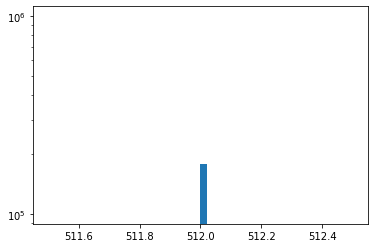

In [25]:
explore_comment_length(xtrain, ytrain)

100%|██████████| 175/175 [00:05<00:00, 29.72it/s]


Number of comments: 44710
Number of toxic comments: 4277
Number of comments longer than 500 tokens: 44710
Number of toxic comments longer than 500 tokens: 4277


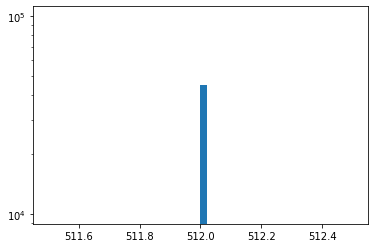

In [26]:
explore_comment_length(xvalid, yvalid)

## Explore tokens

In [ ]:
encoded = tokenizer.encode_batch(['man walks down the street happily don''t you think @fire aslkfd291o'])

print(encoded[0].ids)
for id_item in encoded[0].ids:
    print(tokenizer.id_to_token(id_item))

In [ ]:
#Testcase
fast_tokenizer.token_to_id('[UNK]')
print(fast_tokenizer.token_to_id('Man'))
print(fast_tokenizer.token_to_id('man'))
fast_tokenizer.id_to_token(28995)